In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [69]:
df = pd.read_csv('ecg_autoencoder_dataset.csv', header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,-0.493223,-0.463052,-0.301644,-0.232734,-0.125055,-0.153943,-0.024357,-0.065609,0.034999,0.061935,...,0.337875,0.221405,0.273997,0.298664,0.263564,0.342564,0.419505,0.586607,0.860624,1.173345,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,-0.206160,-0.224480,-0.048684,-0.019621,0.094805,0.116786,0.185186,0.230526,0.138027,0.244426,...,0.172847,0.150779,0.176566,0.280942,0.489939,0.660889,0.893193,1.026997,1.202394,1.557410,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,-0.438023,-0.436248,-0.400114,-0.134987,-0.239347,-0.120244,-0.001971,0.285000,0.315646,0.107364,...,0.403937,0.298191,0.461101,0.664659,0.587757,0.701325,0.917205,1.247987,1.505568,1.640105,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,-0.653949,-0.566916,-0.524045,-0.414711,-0.387787,-0.284437,-0.072745,-0.160125,-0.092160,0.067165,...,0.371639,0.445170,0.484170,0.556061,0.658724,0.861158,1.016397,1.135606,1.216973,1.553079,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439

In [70]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(140, axis=1))
Y = df[140]

In [72]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [73]:
input_dim = x_train.shape[1]

In [75]:
encoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu')
])

decoder = Sequential([
    Input(shape=(16,)),
    Dense(32, activation='relu'),
    Dense(input_dim, activation='linear')
])

autoencoder = Sequential([
    encoder, decoder
])

In [78]:
autoencoder.compile(loss='mean_squared_error', optimizer='adam')
autoencoder.fit(x_train, x_train, epochs=10, batch_size=32, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/10
125/125 [==============================] - 2s 4ms/step - loss: 0.0974 - val_loss: 0.0975
Epoch 2/10
125/125 [==============================] - 0s 3ms/step - loss: 0.0939 - val_loss: 0.0931
Epoch 3/10
125/125 [==============================] - 0s 3ms/step - loss: 0.0902 - val_loss: 0.0913
Epoch 4/10
125/125 [==============================] - 0s 3ms/step - loss: 0.0881 - val_loss: 0.0891
Epoch 5/10
125/125 [==============================] - 0s 3ms/step - loss: 0.0862 - val_loss: 0.0870
Epoch 6/10
125/125 [==============================] - 0s 3ms/step - loss: 0.0847 - val_loss: 0.0877
Epoch 7/10
125/125 [==============================] - 0s 3ms/step - loss: 0.0835 - val_loss: 0.0857
Epoch 8/10
125/125 [==============================] - 1s 4ms/step - loss: 0.0824 - val_loss: 0.0843
Epoch 9/10
125/125 [==============================] - 1s 4ms/step - loss: 0.0815 - val_loss: 0.0839
Epoch 10/10
125/125 [==============================] - 1s 4ms/step - loss: 0.0808 - val_loss: 0.0830

In [83]:
y_pred = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - y_pred, 2), axis=1)

32/32 [==============================] - 0s 2ms/step


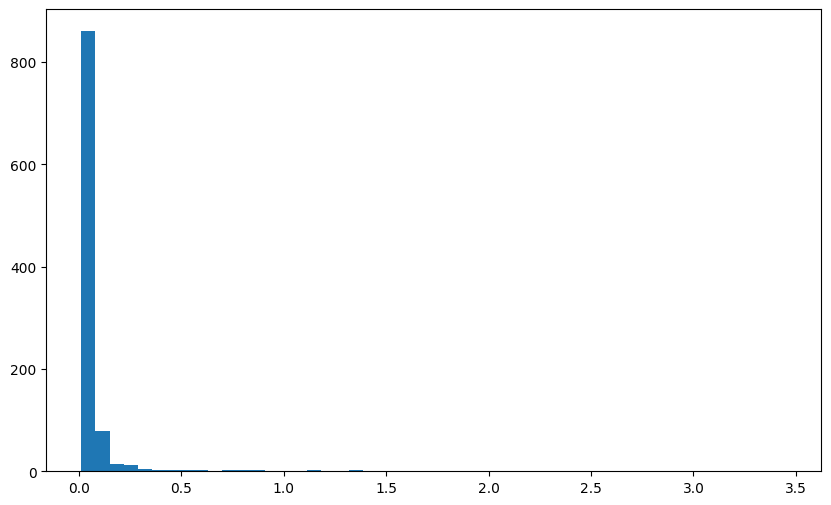

In [86]:
plt.figure(figsize=(10,6))
plt.hist(mse, bins=50)
plt.show()

In [98]:
thresholds = np.arange(0.1, 1.0, 0.1)
for threshold in thresholds:
  anomaly = mse > threshold
  num = np.sum(anomaly)
  print(f"Threshold: {threshold:.1f}, Number of anomalies: {num}")


Threshold: 0.1, Number of anomalies: 103
Threshold: 0.2, Number of anomalies: 48
Threshold: 0.3, Number of anomalies: 31
Threshold: 0.4, Number of anomalies: 28
Threshold: 0.5, Number of anomalies: 24
Threshold: 0.6, Number of anomalies: 20
Threshold: 0.7, Number of anomalies: 18
Threshold: 0.8, Number of anomalies: 15
Threshold: 0.9, Number of anomalies: 10


In [99]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, anomaly))

Confusion Matrix:
[[404   5]
 [586   5]]


In [100]:
print('Classification Report:')
print(classification_report(y_test, anomaly))

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.99      0.58       409
           1       0.50      0.01      0.02       591

    accuracy                           0.41      1000
   macro avg       0.45      0.50      0.30      1000
weighted avg       0.46      0.41      0.25      1000

